Data loading and preprocessing

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

# Download NLTK resources if not already installed
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

# Load the dataset
data = pd.read_csv("/content/sample_data/sdataset.csv")

# Preprocess the text data
def preprocess_text(text):
    """
    Preprocesses the text data by removing stop words and converting to lowercase.
    """
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    return " ".join([word for word in words if word not in stop_words])

data['resume'] = data['Resume'].apply(preprocess_text)
data['jd'] = data['Job Description'].apply(preprocess_text)
data['transcript'] = data['Transcript'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Exploratory Data Analysis(EDA)

               ID          Name               Role  \
count         500           500                500   
unique        500           497                  5   
top     brenbr359  Mark Gilbert  Software Engineer   
freq            1             2                108   

                                               Transcript  \
count                                                 500   
unique                                                500   
top     Product Manager Interview Transcript\n\nInterv...   
freq                                                    1   

                                                   Resume decision  \
count                                                 500      500   
unique                                                500        2   
top     Here's a sample resume for Brent Brown applyin...   select   
freq                                                    1      255   

       Reason for decision                                    Job Descri

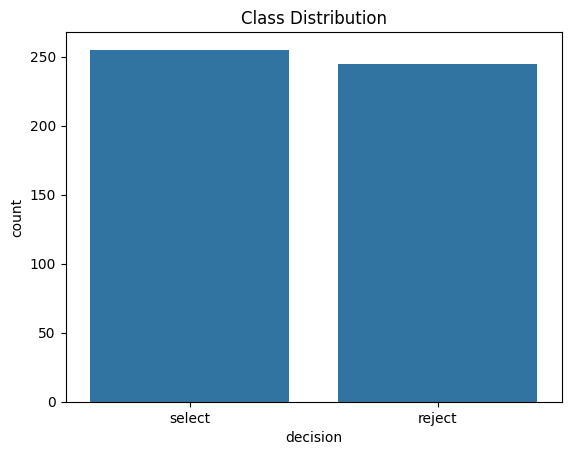

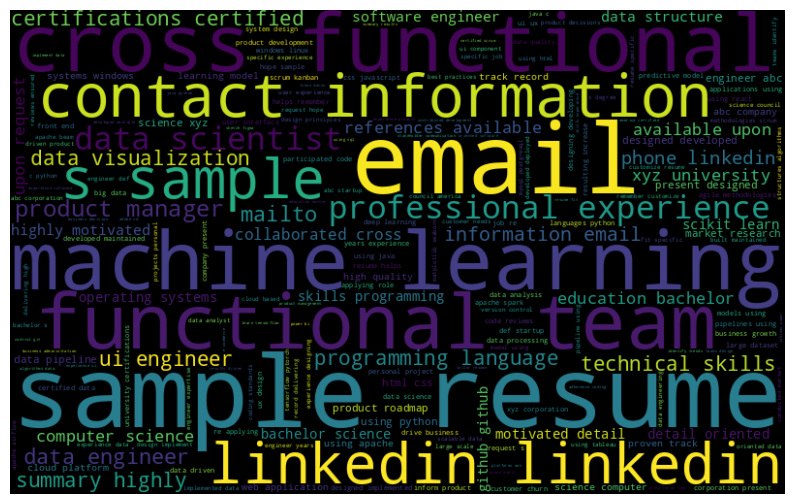

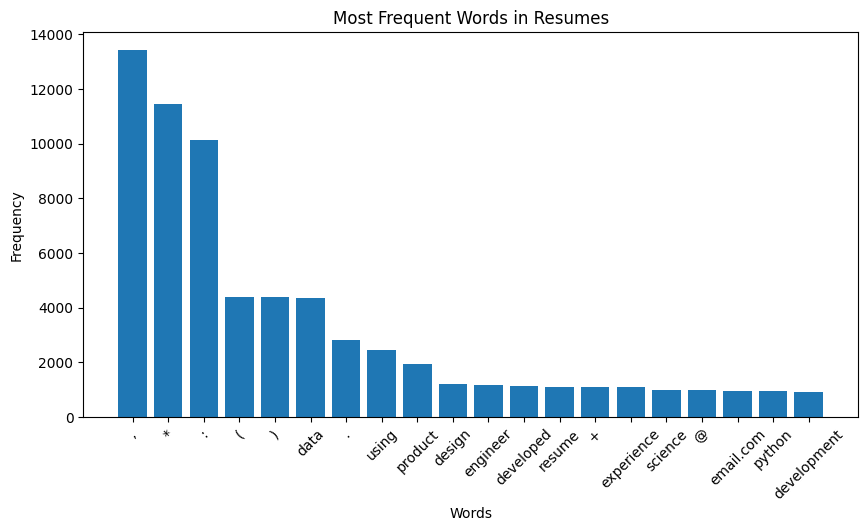

In [2]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# ... (Data Loading and Preprocessing code from previous sections)

# Exploratory Data Analysis (EDA)
print(data.describe())
print(data.isnull().sum())

# Class Distribution
print(data['decision'].value_counts())
sns.countplot(x='decision', data=data)
plt.title('Class Distribution')
plt.show()

# Word Cloud for Resume (Optional)
from wordcloud import WordCloud, STOPWORDS
all_words = ' '.join([text for text in data['resume']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Most Frequent Words in Resumes
all_words = ' '.join([text for text in data['resume']])
word_list = all_words.split()
word_counts = Counter(word_list)
most_common_words = word_counts.most_common(20)
plt.figure(figsize=(10, 5))
plt.bar([word[0] for word in most_common_words], [word[1] for word in most_common_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Most Frequent Words in Resumes')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


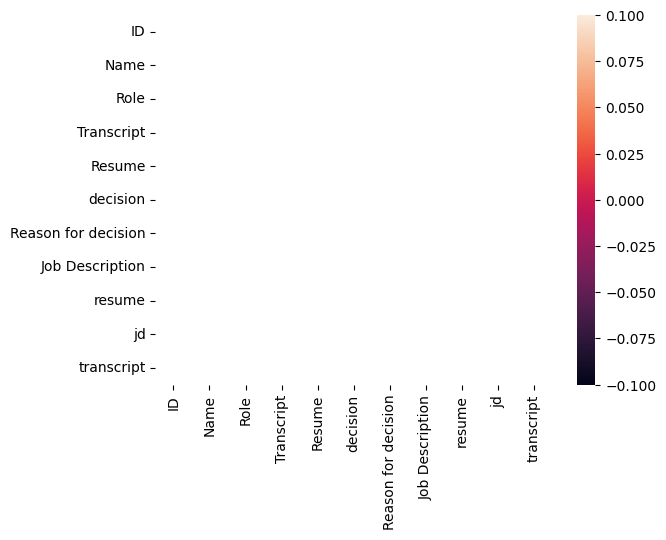

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
numerical_data = data.apply(pd.to_numeric, errors='coerce')
numerical_data = numerical_data.select_dtypes(include=['number'])
correlation_matrix = numerical_data.corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

Feature Extraction

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

def cosine_similarity(text1, text2):
    """
    Calculates cosine similarity between two text documents.
    """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([text1, text2])
    return (tfidf_matrix[0] * tfidf_matrix[1].T).toarray()[0][0]

data['resume_jd_similarity'] = data.apply(lambda row: cosine_similarity(row['Resume'], row['Job Description']), axis=1)

if 'transcript' in data.columns:
    data['resume_transcript_similarity'] = data.apply(lambda row: cosine_similarity(row['Resume'], row['Transcript']), axis=1)

sia = SentimentIntensityAnalyzer()
data['resume_sentiment'] = data['Resume'].apply(lambda x: sia.polarity_scores(x)['compound'])
data['jd_sentiment'] = data['Job Description'].apply(lambda x: sia.polarity_scores(x)['compound'])

data['resume_length'] = data['Resume'].apply(len)
data['jd_length'] = data['Job Description'].apply(len)
if 'transcript' in data.columns:
    data['transcript_length'] = data['Transcript'].apply(len)

In [5]:
print(data[['resume_jd_similarity', 'resume_transcript_similarity', 'resume_sentiment', 'jd_sentiment', 'resume_length', 'jd_length', 'transcript_length']])

     resume_jd_similarity  resume_transcript_similarity  resume_sentiment  \
0                0.215477                      0.391924            0.9953   
1                0.208193                      0.350438            0.9766   
2                0.284605                      0.369080            0.9816   
3                0.251497                      0.393058            0.9924   
4                0.238137                      0.322865            0.9800   
..                    ...                           ...               ...   
495              0.226712                      0.348086            0.9915   
496              0.325768                      0.396972            0.9817   
497              0.227406                      0.404563            0.9814   
498              0.258775                      0.346106            0.9758   
499              0.209814                      0.356825            0.9862   

     jd_sentiment  resume_length  jd_length  transcript_length  
0         

Data Splitting

In [6]:
from sklearn.model_selection import train_test_split
X = data[['resume_jd_similarity', 'resume_transcript_similarity',
          'resume_sentiment', 'jd_sentiment', 'resume_length', 'jd_length',
          'transcript_length']]
y = data['decision']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
le = LabelEncoder()

# Fit the encoder to your training target variable and transform it
y_train = le.fit_transform(y_train)

# Transform the test target variable using the same encoder
y_test = le.transform(y_test)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

param_grids = {
    "Logistic Regression": {'C': [0.01, 0.1, 1, 10]},
    "Decision Tree": {'max_depth': [3, 5, 7, 10]},
    "Random Forest": {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7]},
    "XGBoost": {'n_estimators': [100, 200], 'max_depth': [3, 5, 7], 'learning_rate': [0.1, 0.01]}
}

best_model = None  # Initialize best_model to store the best model
best_roc_auc = 0  # Initialize best_roc_auc to track the best ROC AUC score

for model_name, model in models.items():
    grid_search = GridSearchCV(estimator=model, param_grid=param_grids[model_name],
                              scoring='roc_auc', cv=5)
    grid_search.fit(X_train, y_train)
    y_pred_proba = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    y_pred = grid_search.best_estimator_.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"{model_name}: Accuracy = {accuracy:.4f}, ROC AUC = {roc_auc:.4f}")

    # Update best_model and best_roc_auc if current model is better
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_model = grid_search.best_estimator_

Logistic Regression: Accuracy = 0.4700, ROC AUC = 0.5354
Decision Tree: Accuracy = 0.5700, ROC AUC = 0.5504
Random Forest: Accuracy = 0.5100, ROC AUC = 0.5129
XGBoost: Accuracy = 0.4900, ROC AUC = 0.4881


Post Model analysis

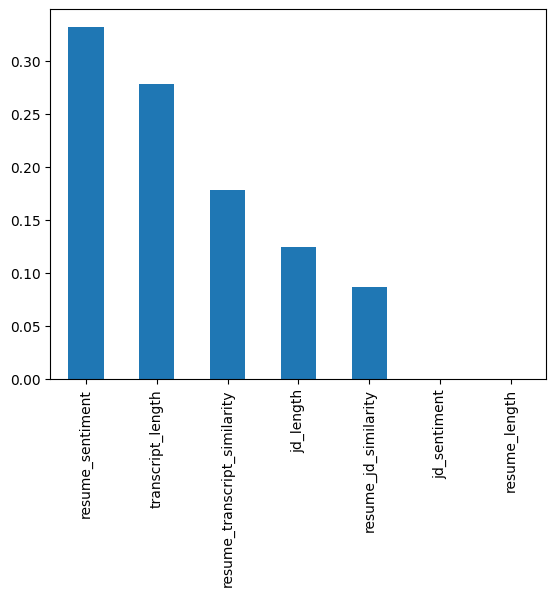

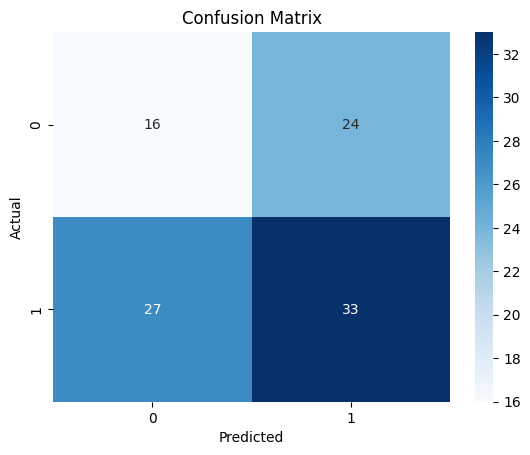

              precision    recall  f1-score   support

           0       0.37      0.40      0.39        40
           1       0.58      0.55      0.56        60

    accuracy                           0.49       100
   macro avg       0.48      0.48      0.47       100
weighted avg       0.50      0.49      0.49       100



In [9]:
if hasattr(best_model, 'feature_importances_'):
    feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)
    feature_importances.sort_values(ascending=False).plot(kind='bar')
    plt.show()
from sklearn.metrics import confusion_matrix, classification_report
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))